# Questions 

# Import, options

In [1]:
import numpy, seaborn, pandas, gseapy
import scipy.stats as stats
import matplotlib, matplotlib.pyplot as plt
import statsmodels.api

from gseapy import barplot, dotplot
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import fcluster
from scipy.stats import linregress

C:\Users\kja11\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
matplotlib.rcParams.update({'svg.fonttype' : 'none'})
#'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20,'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',                            'figure.figsize':(8, 5), 

In [3]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# Data Download

In [4]:
# Values are Protein abundance by TMT reporter ion intensity
# Stats are ANOVA
# Peptides number = 15487

In [5]:
#data Proteomics
df = pandas.read_csv(file_directory+'1) input/proteomics/Pilot_ProteomicsData.csv', 
                     sep = ',', index_col = 'Gene')
df = df.iloc[:,4:-3]

df.columns = df.columns.str.split('_').str[0]
df_with_tripl = df.copy()
df = df.groupby(axis=1, level=0).median()
df = df[['Ctrl', '3h', '6h', '9h', '12h', '16h']]

print(df.shape, '\n')
df.head(3)

(2405, 6) 



C:\Users\kja11\AppData\Local\Temp\ipykernel_23680\3986874491.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(axis=1, level=0).median()


,Ctrl,3h,6h,9h,12h,16h
Gene,,,,,,
DIS3,92.9,96.6,91.6,105.8,103.0,115.5
LARP1,103.3,106.6,103.5,99.1,95.3,93.2
ACTB,100.9,107.1,102.3,94.4,93.9,100.4


In [6]:
# List of filtered proteins
proteomics_path = file_directory + "3) output/Proteomics/"

with open(proteomics_path+'Early_res_CoeffVar_proteins.txt') as f:
    Early_res_CoeffVar_proteins = f.read().splitlines()
    
print("Early_res_CoeffVar_proteins:", len(Early_res_CoeffVar_proteins))

Early_res_CoeffVar_proteins: 179


# Data transformation

## To Zscore 

In [7]:
# Convert to Z_score
df_zscore = stats.zscore(df, axis = 0)
df_zscore.head(2)

,Ctrl,3h,6h,9h,12h,16h
Gene,,,,,,
DIS3,-1.092419,-0.367305,-1.569021,0.917407,0.601398,2.127101
LARP1,0.748607,1.131631,0.843713,-0.246745,-0.859439,-1.056857


# Methods

## Overlapping Early reponse with RNAseq and Screens

The overlapping targets are WDHD1 for RNAseq and 'DCTN3', 'SMYD5', 'DDA1', 'UBA5', 'ARID1A' with screens 

     Gene conditions  value
0   CALD1       Ctrl  108.4
1  POLR3C       Ctrl   88.8
2   DCTN3       Ctrl   91.7
3  ARID1A       Ctrl  105.8
4    DDA1       Ctrl   75.0 



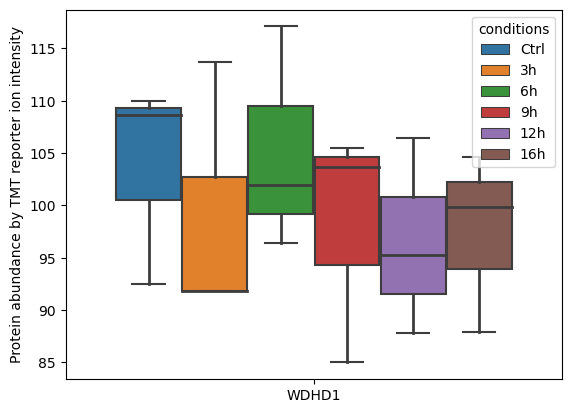

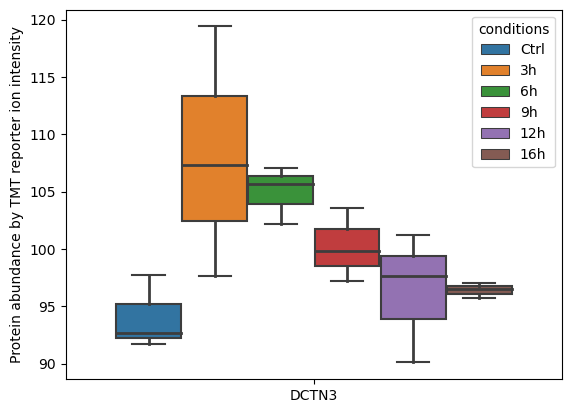

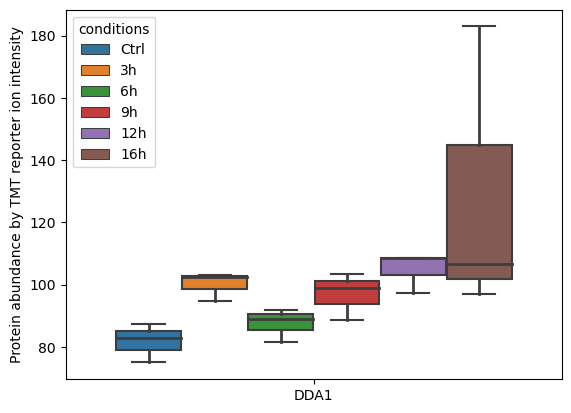

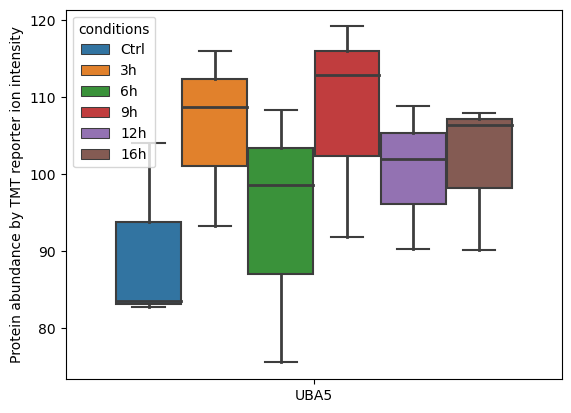

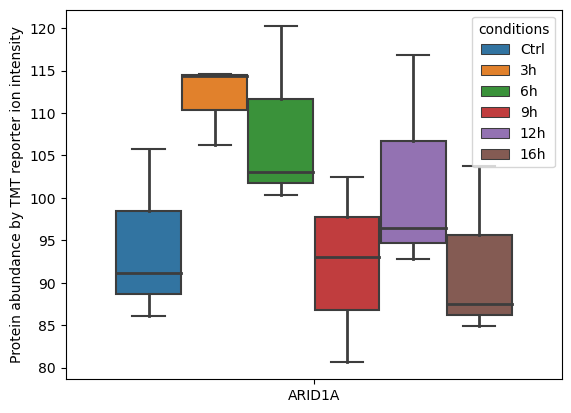

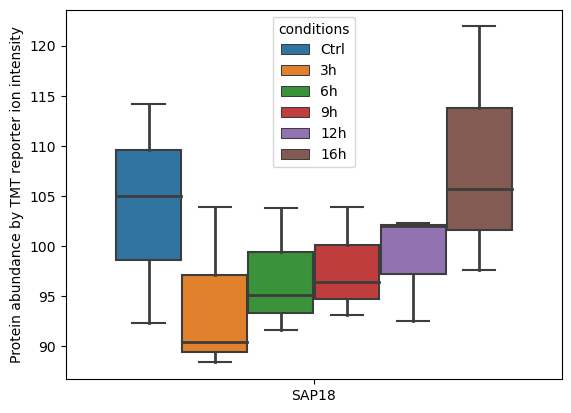

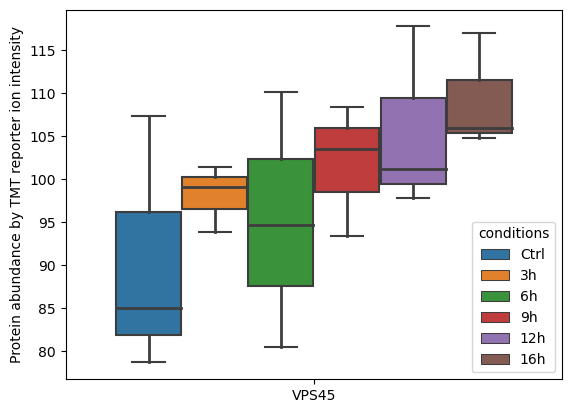

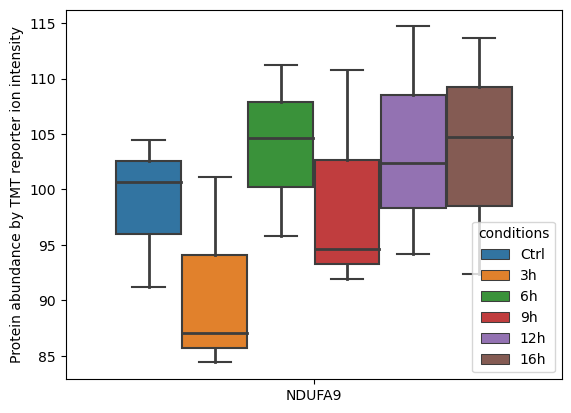

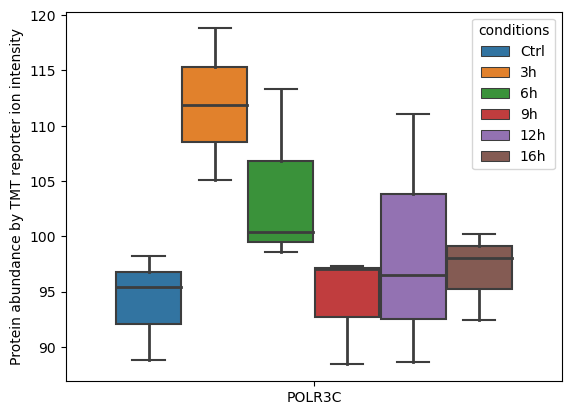

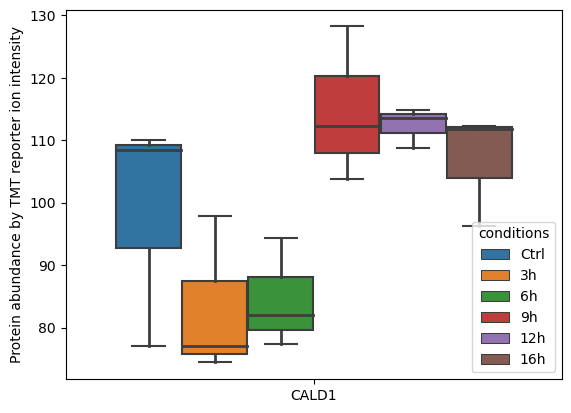

In [8]:
# Select the targets

target_genes = ['WDHD1', 'DCTN3', 'DDA1', 'UBA5', 'ARID1A', 
                'SAP18', 'VPS45', 'NDUFA9', 'POLR3C', 'CALD1']

df_targets = df_with_tripl[df_with_tripl.index.isin(target_genes)]

# From Wide to Long table
df_targets = df_targets.reset_index()
df_targets = df_targets.melt(id_vars=["Gene"], var_name="conditions")

## pull the technical triplicate
df_targets['conditions'] = df_targets['conditions'].str.split('_').str[0]
print(f'{df_targets.head()} \n')

# Expression of the target proteins over time
for target in target_genes:
    df_plt = df_targets[df_targets['Gene'] == target]
    seaborn.boxplot(df_plt, y = 'value', x = 'Gene', hue = 'conditions', 
                medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
    
    plt.ylabel("Protein abundance by TMT reporter ion intensity")
    plt.xlabel("")
    plt.show()
    plt.close()

## Heatmap from expression

### Heatmap of proteins with rvalue > 0.6 (abs)

In [ ]:
# Count number of cells in specific interval to select heatmap vmin/vmax
df_high_Rval = df_zscore[df_zscore.index.isin(high_Rvalue_linregress_proteins)]
print(len(df_high_Rval), df_high_Rval.min().min(), df_high_Rval.max().max(), '\n')

values = df_high_Rval.values.flatten()
bin_edges = numpy.arange(-6, 7, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df)

In [ ]:
# Heatmap of proteins with rvalue > 0.6
## define the colors, one color per condition 
lut = dict(zip(df_high_Rval.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_high_Rval.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_high_Rval))
g =  seaborn.clustermap(df_high_Rval, 
                        cmap='bwr', 
                        row_cluster=True, 
                        col_cluster=False, 
                        vmin=-6.5, vmax=6.5,
                        col_colors = col_colors_conditions,
                        cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                        xticklabels=True, yticklabels=False, 
                        method='complete', metric='cosine')

g.ax_heatmap.xaxis.set_ticks_position('top')
g.ax_heatmap.xaxis.set_label_position('top')


### Select the Overtime Downregulated and Upregulated proteins

In [ ]:
sample_names = df_high_Rval.index
num_samples = len(sample_names)

reordered_indices = g.dendrogram_row.reordered_ind #the index in the heatmap
linkage_matrix  = g.dendrogram_row.linkage #the matrix for heatmap
num_clusters = 2 # cluster expected

#Get the cluster labels for each sample
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
print(cluster_labels[:10])

groupDown_samples = [sample_names[i] for i in range(len(sample_names)) if cluster_labels[i] == 1]
groupUp_samples = [sample_names[i] for i in range(len(sample_names)) if cluster_labels[i] == 2]
print(groupUp_samples[:10])

print(f'\nn = {len(groupDown_samples)} down regulated overtime.\nn= {len(groupUp_samples)} up regulated overtime')

In [ ]:
# See if the selection is good
for subgroup in groupDown_samples, groupUp_samples:
    plt.subplots(figsize=(2, 2))
    
    seaborn.heatmap(df_high_Rval[df_high_Rval.index.isin(subgroup)],
                    annot=False, cmap="bwr", 
                    linewidths=0, center=0, vmin=-6.5, vmax=6.5,
                    cbar_kws={'label': 'Zscore \n protein expression'})
    plt.show()

### EnrichR

In [ ]:
import warnings
# Filter out the specific warning
warnings.filterwarnings("ignore", message="The 'method' keyword in Series.replace is deprecated")
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy")

In [ ]:
# names = gseapy.get_library_name(organism='Human')
# names

### Overtime Down regulated proteins

In [ ]:
# Perform GO enrichment analysis using Enrichr
subgroups = groupDown_samples, groupUp_samples
sub_labels ='OvTime - Down regulated', 'OvTime - Up regulated'

for i in range(len(subgroups)):
    subgroup = subgroups[i]
    sub_label = sub_labels[i]
    
    enr_TF = gseapy.enrichr(gene_list = subgroup,
                            gene_sets= ['ARCHS4_TFs_Coexp',
                                        'Transcription_Factor_PPIs',
                                        'huMAP'],
                            organism='Human',
                            outdir='Enrichr_results',
                            cutoff=0.05)

    # categorical scatterplot
    colors = seaborn.hls_palette(3)
    barplot(enr_TF.results,
            column="Adjusted P-value",
            group='Gene_set',
            size=10,
            top_term=5,
    #         figsize=(3,5),
            title=f'Transcription Factors results from\n{sub_label} proteins\n',
            color=colors)
    del enr_TF

In [ ]:
# Perform GO enrichment analysis using Enrichr
subgroups = groupDown_samples, groupUp_samples
sub_labels =' OvTime - Down regulated', 'OvTime - Up regulated'

for i in range(len(subgroups)):
    subgroup = subgroups[i]
    sub_label = sub_labels[i]
    
    enr = gseapy.enrichr(gene_list = subgroup,
                         gene_sets= ['GO_Molecular_Function_2021',
                                     'PPI_Hub_Proteins',
                                     'Reactome_2022'],
                         organism='Human',
                         outdir='Enrichr_results',
                         cutoff=0.05)

     # categorical scatterplot
    colors = seaborn.hls_palette(3)
    barplot(enr.results,
            column="Adjusted P-value",
            group='Gene_set', # set group, so you could do a multi-sample/library comparsion
    #         size=30,
            top_term=5,
            color=colors,
            title=f'Enrichment results from\n{sub_label} proteins\n',)